In [9]:
'''import thpe libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import hashlib
import joblib
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
'''load the data. It's big, set low_memory=False'''
loan_data = pd.read_csv('/opt/apps/ml-data/bigdata/lending_club/loan_data.csv', low_memory=False)

In [11]:
'''Update the datetime columns from String to datetime'''
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'])
loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'])

In [12]:
loan_data['addr_state'].unique()

'''Make a list with each of the regions by state.'''
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']


loan_data['Region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'South West'
    elif state in south_east:
        return 'South East'
    elif state in mid_west:
        return 'Mid West'
    elif state in north_east:
        return 'North East'


loan_data['Region'] = loan_data['addr_state'].apply(finding_regions)
loan_data['Region'].value_counts()

South East    323587
West          318529
North East    301767
Mid West      232678
South West    161663
Name: Region, dtype: int64

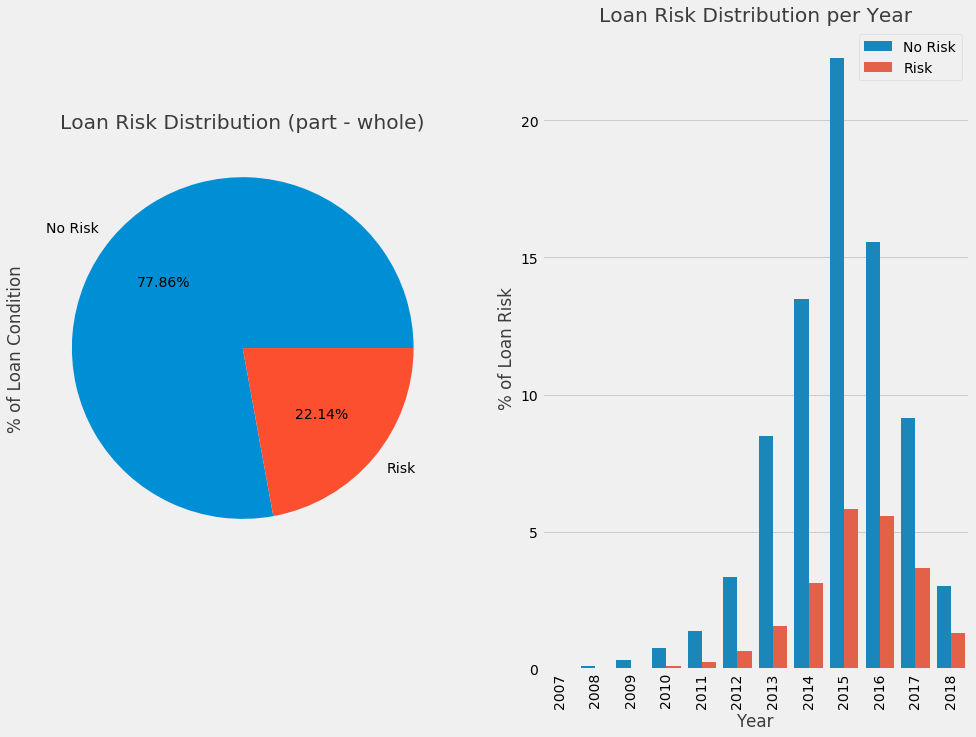

In [17]:
'''Pie and Bar comparison of the loan status'''
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 11))
plt.style.use('fivethirtyeight') 


plt.subplot(1, 2, 1)
risk_counts = loan_data['Risk'].value_counts()
risk_counts.plot.pie(autopct='%1.2f%%')

plt.title('Loan Risk Distribution (part - whole)', alpha = 0.75)
plt.xlabel('')
plt.ylabel('% of Loan Condition', alpha = 0.75)


plt.subplot(1, 2, 2)
g = sns.barplot(x=loan_data['issue_d'].dt.year, y="loan_amnt", 
            hue="Risk", data=loan_data, 
            estimator=lambda x: len(x) / len(loan_data) * 100)
plt.title('Loan Risk Distribution per Year', alpha = 0.75)
plt.xlabel('Year', alpha = 0.75)
plt.ylabel('% of Loan Risk', alpha = 0.75)
plt.xticks(rotation=90)


l = g.legend()
l.texts[0].set_text("No Risk")
l.texts[1].set_text("Risk")
plt.savefig('1.png')
plt.show()

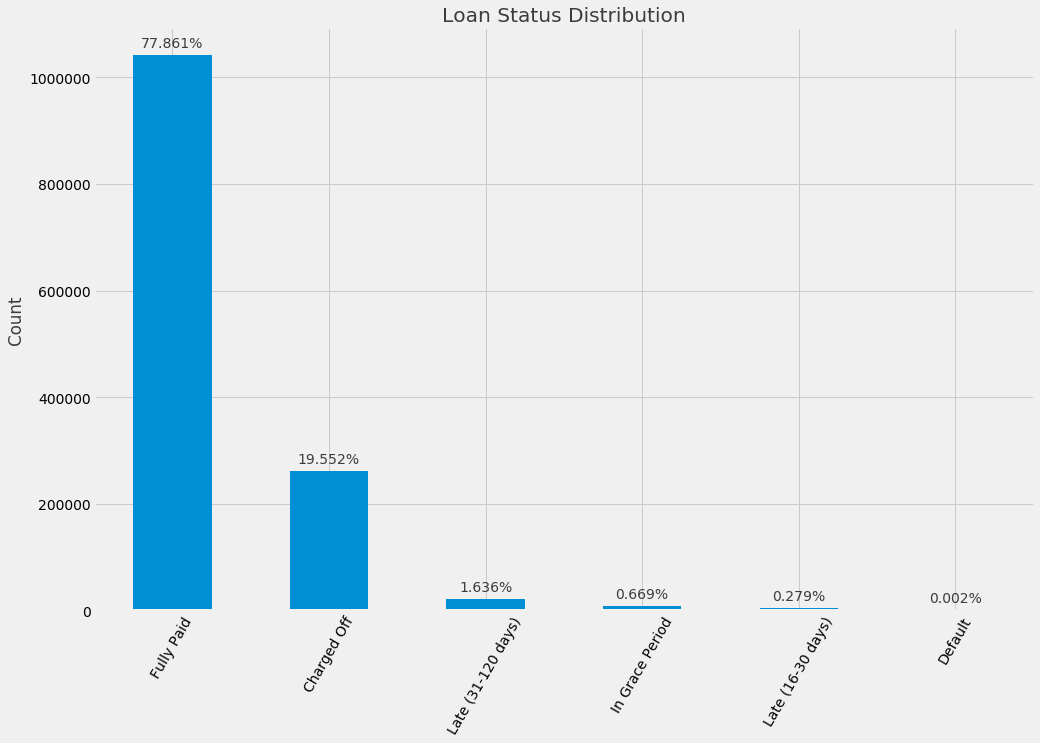

In [6]:
'''What defines good or bad loan? Show the count plot of loan status count.'''
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 10))
plt.style.use('fivethirtyeight')

loan_data['loan_status'].value_counts().plot.bar()

total = float(len(loan_data['loan_status']))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+15000,
            '{:1.3f}%'.format((height/total)*100),
            ha="center", alpha=0.75) 

plt.title('Loan Status Distribution', alpha=0.75)
plt.ylabel('Count', alpha=0.75)
plt.xlabel('')
plt.xticks(rotation=60)

plt.savefig('2.png')
plt.show()

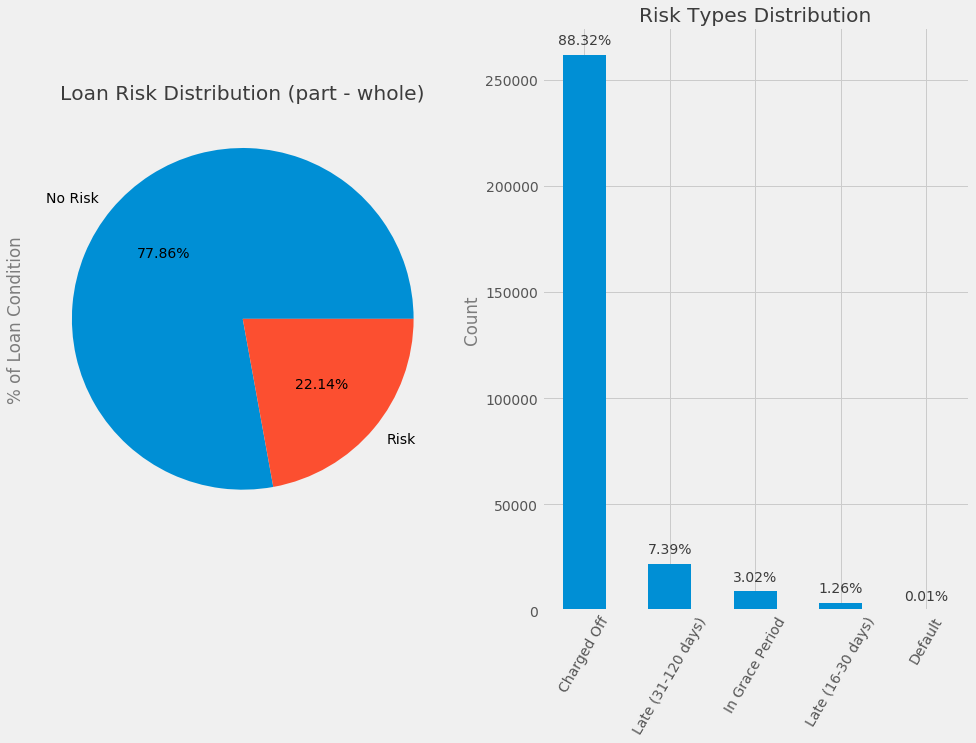

In [123]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 10))
plt.style.use('fivethirtyeight')


plt.subplot(1, 2, 1)
risk_counts = loan_data['Risk'].value_counts()
risk_counts.plot.pie(autopct='%1.2f%%')

plt.title('Loan Risk Distribution (part - whole)', alpha=0.75)
plt.xlabel('')
plt.ylabel('% of Loan Condition', alpha=0.75)


plt.subplot(1, 2, 2)
bad_loan = loan_data[loan_data['loan_status'] != 'Fully Paid']
bad_counts = bad_loan['loan_status'].value_counts()
plot = bad_counts.plot.bar()
total = float(len(bad_loan['loan_status']))

for p in plot.patches:
    height = p.get_height()
    plot.text(p.get_x()+p.get_width()/2.,
            height+5000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", alpha=0.75) 

plt.title('Risk Types Distribution', alpha=0.75)
plt.ylabel('Count', alpha=0.75)
plt.xlabel('')
plt.xticks(rotation=60)

plt.savefig('plots/3.png')
plt.show()

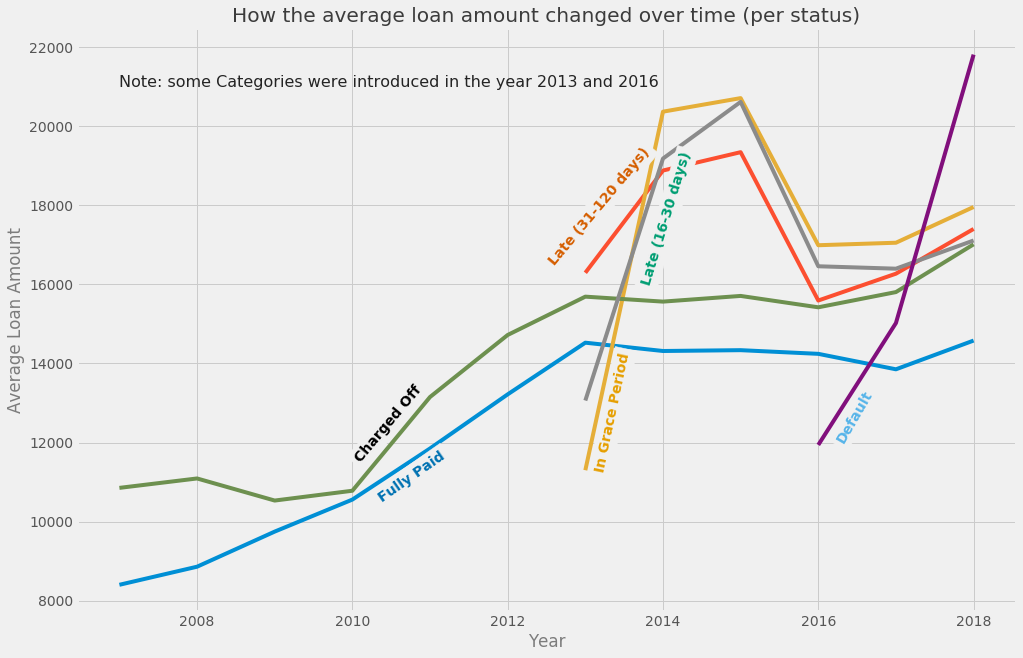

In [78]:
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 10))
plt.style.use('fivethirtyeight')

sns.lineplot(x=loan_data['issue_d'].dt.year, y='loan_amnt', 
             hue='loan_status', data=loan_data, ci=None, legend=False)

plt.text(x=2007, y=21000, s='Note: some Categories were introduced in the year 2013 and 2016', 
         fontsize=16, alpha=0.85)

plt.text(x=2010, y=11500, s='Charged Off', color = colors[0], weight='bold', rotation=50,
              backgroundcolor='#f0f0f0')
plt.text(x=2010.3, y=10500, s='Fully Paid', color = colors[5], weight='bold', rotation=35,
              backgroundcolor='#f0f0f0')
plt.text(x=2012.5, y=16500,s ='Late (31-120 days)', color = colors[4], weight='bold', rotation=50,
              backgroundcolor='#f0f0f0')
plt.text(x=2013.7, y=16000, s='Late (16-30 days)', color = colors[3], weight='bold', rotation=73,
              backgroundcolor='#f0f0f0')
plt.text(x=2013.1, y=11300, s='In Grace Period', color = colors[1], weight='bold', rotation=78,
              backgroundcolor='#f0f0f0')
plt.text(x=2016.2, y=12000, s='Default', color = colors[2], weight='bold', rotation=60,
              backgroundcolor='#f0f0f0')

plt.title('How the average loan amount changed over time (per status)', alpha=0.75)
plt.xlabel('Year', alpha=0.75)
plt.ylabel('Average Loan Amount in dollars', alpha=0.75)
    
plt.show()

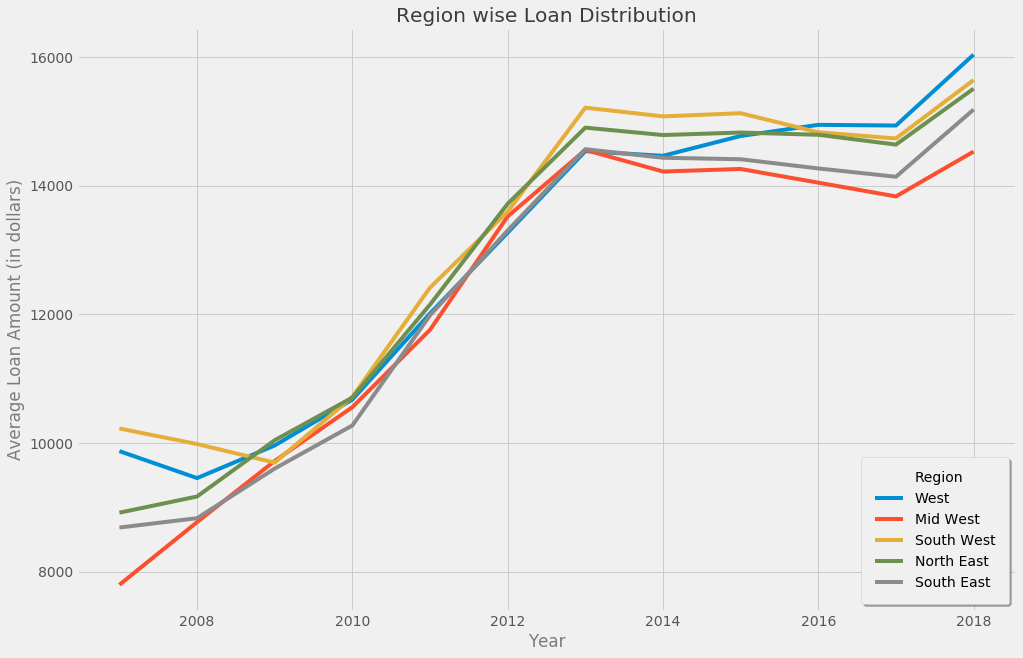

In [93]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 10))
plt.style.use('fivethirtyeight')

sns.lineplot(x=loan_data['issue_d'].dt.year, y="loan_amnt", hue="Region", data=loan_data, ci=None)

plt.title('Region wise Loan Distribution', alpha=0.75)
plt.xlabel('Year', alpha=0.75)
plt.ylabel('Average Loan Amount (in dollars)', alpha=0.75)

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='lower right')

plt.show()

In [96]:
'''Data preparation for map'''
by_loan_amount = loan_data.groupby(['Region','addr_state'], as_index=False).loan_amnt.sum()
by_interest_rate = loan_data.groupby(['Region', 'addr_state'], as_index=False).int_rate.mean()
by_income = loan_data.groupby(['Region', 'addr_state'], as_index=False).annual_inc.mean()

'''Take the values to a list for visualization purposes.'''
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amnt'].values.tolist()
average_interest_rates = by_interest_rate['int_rate'].values.tolist()
average_annual_income = by_income['annual_inc'].values.tolist()


from collections import OrderedDict

metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()

,state_codes,issued_loans,interest_rate,annual_income
0,IA,70375,10.87,47570.86
1,IL,756318450,13.14,77966.43
2,IN,303676075,13.47,69004.47
3,KS,156932250,13.20,69805.09
4,MI,485185900,13.42,70059.69


In [18]:
'''Now it comes the part where we plot out plotly United States map'''
for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "USD")
        ) ]


layout = dict(
    title = '',
    width=925,
    height=700,
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
    )

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')